In [1]:
import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',
    database='naxos_db'
)

query = """
SELECT
    a.release_date,
    a.label,
    g.genre
FROM Album AS a
JOIN AlbumGenre AS g ON g.catalogue_no = a.catalogue_no
"""

df = pd.read_sql(query, connection)
connection.close()

df.release_date = pd.to_datetime(df.release_date)
df.head()

C:\Users\jakob\AppData\Local\Temp\ipykernel_6728\1159928941.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,release_date,label,genre
0,2014-01-01,SWR Jazzhaus,Contemporary Jazz
1,2014-01-01,SWR Jazzhaus,Jazz
2,NaT,SWR Jazzhaus,Jazz
3,2013-01-01,SWR Jazzhaus,Jazz
4,2013-12-01,SWR Jazzhaus,Jazz


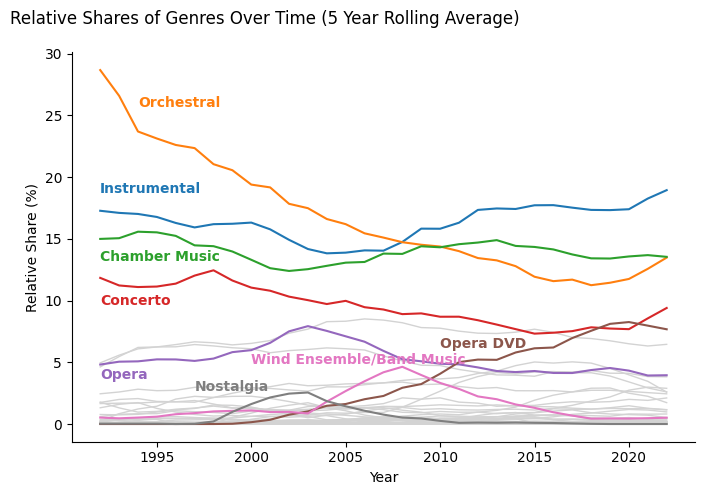

In [96]:
df["year"] = df["release_date"].dt.year
genre_trends = df.query("year >= 1990").groupby(["year", "genre"]).size().unstack(fill_value=0)

# Genres to highlight
highlight_genres = [
    "Instrumental",
    "Orchestral",
    "Chamber Music",
    "Concerto",
    "Opera",
    "Opera DVD",
    "Wind Ensemble/Band Music",
    "Nostalgia",
]

genre_trends_relative = genre_trends.div(genre_trends.sum(axis=1), axis=0) * 100

# Rolling mean with a window of 5 years
genre_trends_smoothed = genre_trends_relative.rolling(window=5, center=True).mean()

fig = plt.figure(figsize=(7, 5))

# Other genres
for genre in genre_trends_smoothed.columns:
    if genre not in highlight_genres:
        plt.plot(
            genre_trends_smoothed.index,
            genre_trends_smoothed[genre],
            color="lightgrey",
            linewidth=1,
            label="_nolegend_",
        )

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for genre, color in zip(highlight_genres, color_cycle[:len(highlight_genres)]):
    plt.plot(genre_trends_smoothed.index, genre_trends_smoothed[genre], color=color, label=genre)



highlight_colors = color_cycle[:len(highlight_genres)]
highlight_labels = {
    "Instrumental": (1992, 19),
    "Orchestral": (1994, 26),
    "Chamber Music": (1992, 13.5),
    "Concerto": (1992, 10),
    "Opera": (1992, 4),
    "Opera DVD": (2010, 6.5),
    "Wind Ensemble/Band Music": (2000, 5.2),
    "Nostalgia": (1997, 3),
}

for genre, color in zip(highlight_genres, highlight_colors):
    x_pos, y_pos = highlight_labels[genre]
    plt.text(x_pos, y_pos, genre, color=color, fontsize=10, weight="demibold", ha="left", va="center")

# Titles and labels
fig.suptitle("Relative Shares of Genres Over Time (5 Year Rolling Average)", fontsize=12, x=0.0, ha="left")
plt.xlabel("Year")
plt.ylabel("Relative Share (%)")

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
